In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import cv2
import glob
import time
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
import os

##### Methods for feature extraction

###### 1. Spatial binning

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    spatial_features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return spatial_features

##### 2. Color histogram

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 1)):
#     img = img * 255
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

##### 3. HOG

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

##### Feature extraction

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

### Set the hyper parameters and extract the features

In [6]:

# Read in car and non-car images
cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')

# Hyper parameters that needs tuning
spatial = 8
histbin = 12
orient = 5
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
cspace = 'YCrCb'

hyper_params = {}
hyper_params["spatial"] = spatial
hyper_params["histbin"] = histbin
hyper_params["orient"] = orient
hyper_params["pix_per_cell"] = pix_per_cell
hyper_params["cell_per_block"] = cell_per_block
hyper_params["hog_channel"] = hog_channel
hyper_params["cspace"] = cspace
pickle.dump(hyper_params, open("hyper_params.p", "wb"))

car_features = extract_features(cars, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X, y = shuffle(X, y)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

pickle.dump(X_train, open("X_train.p", "wb"))
pickle.dump(X_test, open("X_test.p", "wb"))
pickle.dump(y_train, open("y_train.p", "wb"))
pickle.dump(y_test, open("y_test.p", "wb"))
pickle.dump(X_scaler, open("X_scaler.p", "wb"))

print('Using spatial binning of:',spatial, 'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))


Using spatial binning of: 8 and 12 histogram bins
Feature vector length: 1208


### Train the classifier

In [7]:
with open('X_train.p', mode='rb') as f:
    X_train = pickle.load(f)
with open('X_test.p', mode='rb') as f:
    X_test = pickle.load(f)
with open('y_train.p', mode='rb') as f:
    y_train = pickle.load(f)
with open('y_test.p', mode='rb') as f:
    y_test = pickle.load(f)

# Use a linear SVC 
# clf = LinearSVC()
clf = SVC(kernel='rbf')

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
pickle.dump(clf, open("clf.p", "wb"))
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My classifier predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels:    ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with clf')

92.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9739
My classifier predicts:  [ 1.  0.  0.  0.  1.  0.  1.  1.  1.  1.]
For these 10 labels:     [ 1.  0.  0.  0.  1.  0.  1.  0.  1.  1.]
0.06949 Seconds to predict 10 labels with clf


The classifier is trained and saved in a pickle file named "clf.p", I have also saved the standardScalar object in "X_scaler.p"

now I can directly load my classifier from pickle file and use it in my pipeline.

## Designing the pipeline

In [7]:
# load the data from pickle file

with open('clf.p', mode='rb') as f:
    clf = pickle.load(f)
with open('hyper_params.p', mode='rb') as f:
    hyper_params = pickle.load(f)
with open('X_scaler.p', mode='rb') as f:
    X_scaler = pickle.load(f)
    
spatial = hyper_params['spatial']
histbin = hyper_params['histbin']
orient = hyper_params['orient']
pix_per_cell = hyper_params['pix_per_cell']
cell_per_block = hyper_params['cell_per_block']
hog_channel = hyper_params['hog_channel']
cspace = hyper_params['cspace']

In [8]:
def get_features(image, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel):
    # Resize the image
#     print("image -", image.shape)
    image = cv2.resize(image,(64,64))
    # change to png format as the training was done on png images
    image = image.astype(np.float32)/255
    # Create a list to append feature vectors to
    features = []
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
        
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
      
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
    # Append the new feature vector to the features list
    features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    features = np.array(features).astype(np.float64)
#     features = features.reshape(-1,1)
#     print(features.shape)
    features = X_scaler.transform(features)
    
    return features

In [38]:
class VideoProcessor():
#     ctr = 0
    def __init__(self):
        self.frame = None
        self.heatmap_avg = None
        self.heatmap_previous = []
        
    def slide_window(self, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = self.frame.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = self.frame.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list

    def draw_boxes(self, bboxes, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        draw_img = np.copy(self.frame)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return draw_img
    
    def run_classifier(self, windows_all):
        windows_detected = []
        # Iterate through all windows
        for window in windows_all:
            crop = self.frame[window[0][1]:window[1][1], window[0][0]:window[1][0]]
            features = get_features(crop)
#             print(clf.predict(features), end=" ")
            if clf.predict(features) == 1:
                windows_detected.append(window)
        return windows_detected
    
    def generate_heatmap(self, windows_detected):
        heatmap = np.zeros_like(self.frame[:,:,0]).astype(np.float)
        for window in windows_detected:
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
#             VideoProcessor.ctr += 1
#             name = str(VideoProcessor.ctr)+".png"
#             plt.imsave(name,self.frame[window[0][1]:window[1][1], window[0][0]:window[1][0]])
            
        self.heatmap_previous.append(heatmap)
        return heatmap
    
    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    def avg_heatmap(self, heatmap):
        self.heatmap_previous = self.heatmap_previous[-7:]
        self.heatmap_avg = sum(self.heatmap_previous)/len(self.heatmap_previous)
        return self.heatmap_avg
    
    def label_heatmap(self, heatmap_avg):
        labels = label(heatmap_avg)
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            x_len = np.max(nonzerox) - np.min(nonzerox)
            y_len = np.max(nonzeroy) - np.min(nonzeroy)
            
            if x_len > 30 and y_len > 40:# and x_len > y_len:
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
                
                # Draw the box on the image
                cv2.rectangle(self.frame, bbox[0], bbox[1], (0,0,255), 2)
        
    def pipeline(self, frame):
        self.frame = frame
        original = np.copy(frame)
        # this function returns the xy coordinates of all the windows
        windows_big = self.slide_window(x_start_stop=[550, None], y_start_stop=[350, 700], 
                                        xy_window=(96, 96), xy_overlap=(0.8, 0.75))
        windows_med = self.slide_window(x_start_stop=[550, None], y_start_stop=[400, 600], 
                                        xy_window=(64, 64), xy_overlap=(0.75, 0.75))
        windows_small = self.slide_window(x_start_stop=[760, 1180], y_start_stop=[400, 500], 
                                        xy_window=(56, 56), xy_overlap=(0.75, 0.75))
        windows_spec = self.slide_window(x_start_stop=[660, 1280], y_start_stop=[420, 660], 
                                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))
        windows_all = windows_med + windows_big + windows_spec + windows_small 

        # this function returns the xy coordinates of windows in which vehicle is detected
        windows_detected = self.run_classifier(windows_all)
        # uncomment this line to see all the detected windows
#         self.frame = self.draw_boxes(windows_detected, color=(0, 255, 0), thick=2)
        
        # this function returns the heatmap for the detected vehicle locations
        heatmap = self.generate_heatmap(windows_detected)
        # get the average value of the heatmap
        heatmap_avg = self.avg_heatmap(heatmap)
        # apply threshold over the heatmap
        heatmap_avg = self.apply_threshold(heatmap_avg, threshold=7)
        
        # this function draws boxes around the detected vehicle
        self.label_heatmap(heatmap_avg)
        
        # uncomment this to view heatmaps
#         f, (ax1, ax2) = plt.subplots(2, 2, figsize=(16,9))
#         ax1[0].imshow(original)
#         ax1[0].set_title("Input image")
#         ax1[1].imshow(heatmap, cmap='hot')
#         ax1[1].set_title('Heatmap before applying threshold')
#         ax2[0].imshow(heatmap_avg, cmap='hot')
#         ax2[0].set_title('Heatmap after applying threshold')
#         self.label_heatmap(heatmap_avg)
#         ax2[1].imshow(self.frame)
#         ax2[1].set_title("Bounding box drawn over the vehicle")
        
#         stiched = np.hstack((self.frame, np.dstack((heatmap_avg,heatmap_avg,heatmap_avg)))).astype(np.uint8)
        return self.frame

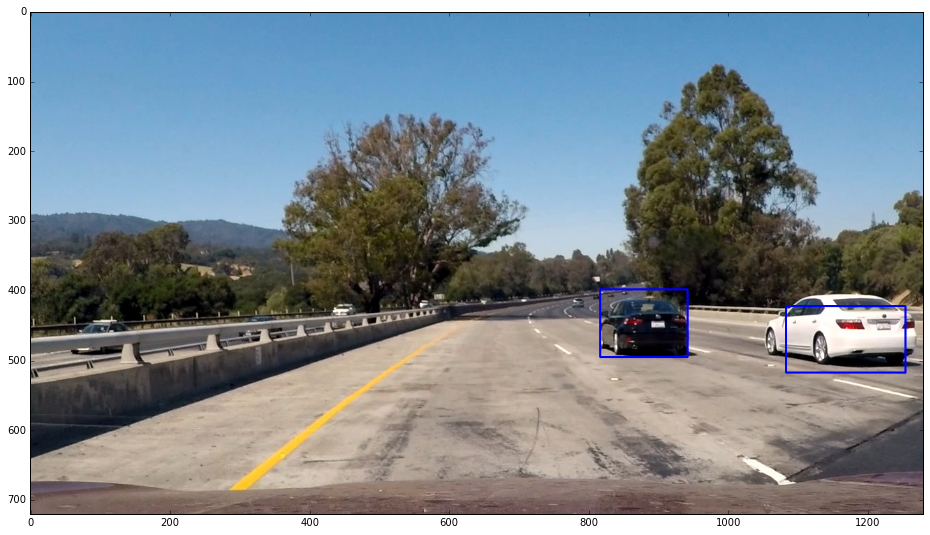

In [47]:
img = mpimg.imread('./test_images/test1.jpg')
video_processor = VideoProcessor()
img = video_processor.pipeline(img)
f, ax1 = plt.subplots(1, 1, figsize=(16,9))
ax1.imshow(img)
# ax2.imshow(heatmap, cmap='hot')

### Running the pipeline on video

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# create a folder to store the output video
if(not(os.path.exists("./video_output"))):
    os.mkdir("video_output/")
video_processor = VideoProcessor()    
video_output = 'video_output/project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")#.subclip(49,None)
# clip1 = VideoFileClip("./test_video.mp4")
processed_clip = clip1.fl_image(video_processor.pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video video_output/project_video.mp4
[MoviePy] Writing video video_output/project_video.mp4


100%|███████████████████████████████████▉| 1260/1261 [4:00:30<00:11, 11.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video.mp4 

Wall time: 4h 33s


#### Visualizations

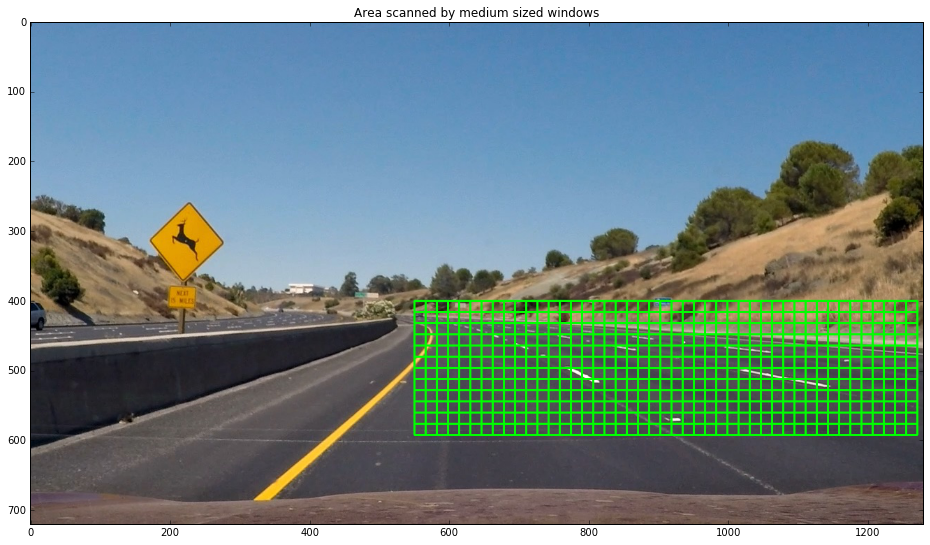

In [15]:
img = mpimg.imread('./test_images/test2.jpg')
video_processor = VideoProcessor()
img = video_processor.pipeline(img)
f, ax1 = plt.subplots(1, 1, figsize=(16,9))
ax1.imshow(img)
ax1.set_title("Area scanned by medium sized windows")

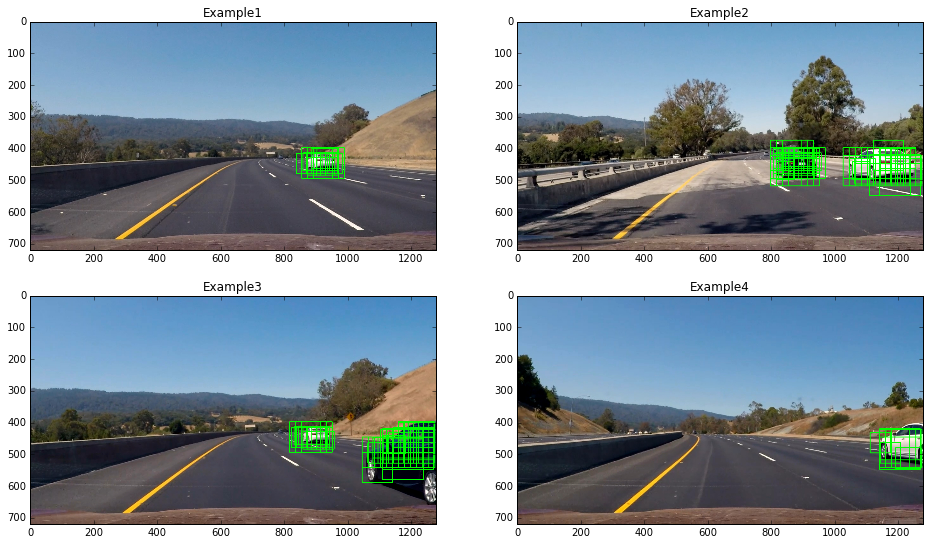

In [23]:
img1 = mpimg.imread('./test_images/test3.jpg')
img2 = mpimg.imread('./test_images/test4.jpg')
img3 = mpimg.imread('./test_images/snap8.jpg')
img4 = mpimg.imread('./test_images/snap6.jpg')
video_processor = VideoProcessor()
img1 = video_processor.pipeline(img1)
img2 = video_processor.pipeline(img2)
img3 = video_processor.pipeline(img3)
img4 = video_processor.pipeline(img4)
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(16,9))
ax1[0].imshow(img1)
ax1[0].set_title("Example1")
ax1[1].imshow(img2)
ax1[1].set_title("Example2")
ax2[0].imshow(img3)
ax2[0].set_title("Example3")
ax2[1].imshow(img4)
ax2[1].set_title("Example4")

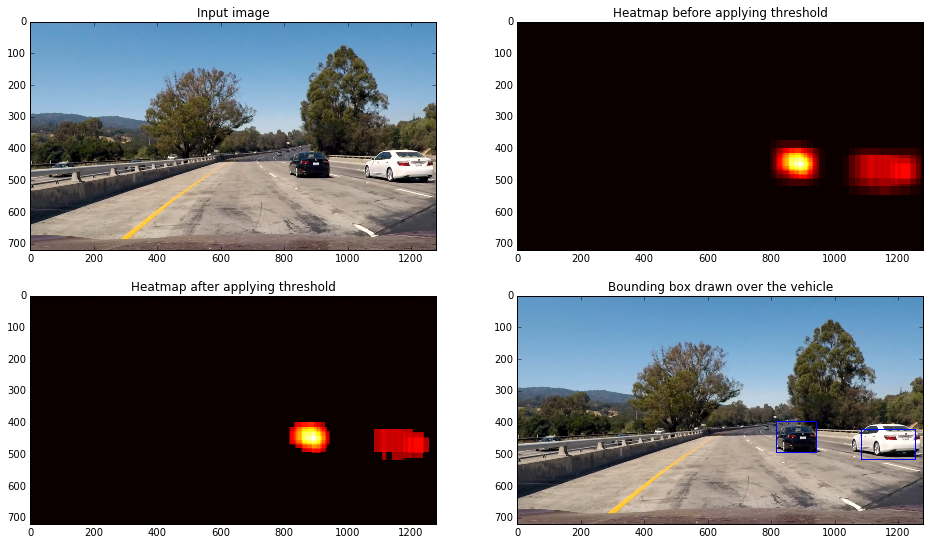

In [37]:
img = mpimg.imread('./test_images/test1.jpg')
video_processor = VideoProcessor()
img = video_processor.pipeline(img)

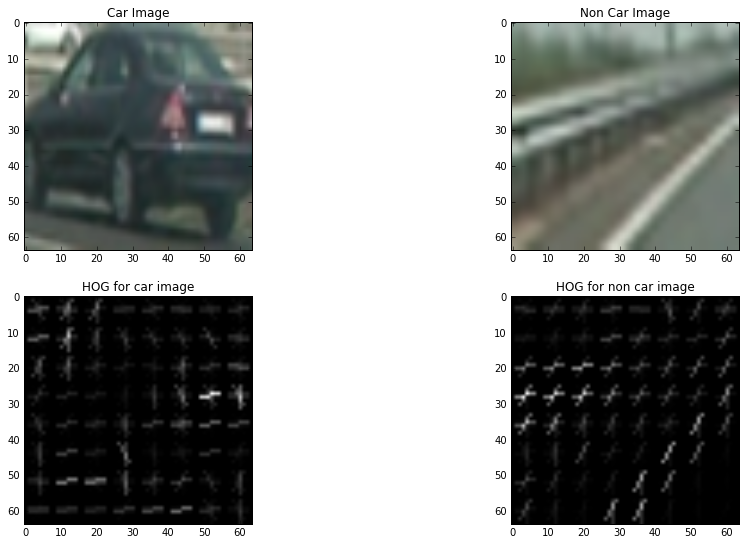

In [46]:
car_img = mpimg.imread('./data/vehicles/GTI_Right/image0130.png')
ncar_img = mpimg.imread('./data/non-vehicles/GTI/image8.png')
feature_image = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
nfeature_image = cv2.cvtColor(ncar_img, cv2.COLOR_RGB2YCrCb)
f, hog_img = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
nf, nhog_img = get_hog_features(nfeature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(16,9))
ax1[0].imshow(car_img)
ax1[0].set_title("Car Image")
ax1[1].imshow(ncar_img)
ax1[1].set_title("Non Car Image")
ax2[0].imshow(hog_img, cmap='gray')
ax2[0].set_title("HOG for car image")
ax2[1].imshow(nhog_img, cmap='gray')
ax2[1].set_title("HOG for non car image")